## Finding Your Way In The City

In this notebook you'll combine the work of previous exercises to calculate a minimal series of waypoints in order to get from a start location to a goal location.

You'll reuse and modify your algorithms from:

- A*
- Configuration Space
- Collinearity and/or Bresenham

In [1]:
%load_ext autoreload

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from bresenham import bresenham

In [3]:
%autoreload 2
from grid import create_grid
from planning import a_star

In [4]:
plt.rcParams['figure.figsize'] = 12, 12

You'll notice we've imported `create_grid`, and `a_star`. These are functions you've implemented in previous exercises, and here you'll use them to create a map and find a path from a starting position to a goal position.

To read the function signature and documentation execute `?` followed by the function name in a cell. In the example below we'll check the documentation for `create_grid`.

In [5]:
?create_grid

If you would like to alter these implementations, you can modify [grid.py](/edit/grid.py) and [planning.py](/edit/planning.py) in the current directory.

In [6]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ..., 
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


In [7]:
# Static drone altitude (meters)
drone_altitude = 5

# Minimum distance stay away from obstacle (meters)
safe_distance = 3

In [8]:
%autoreload 2
from grid import create_grid

# Use `create_grid` to create a grid configuration space of
# the obstacle data.
grid = create_grid(data, drone_altitude, safe_distance)

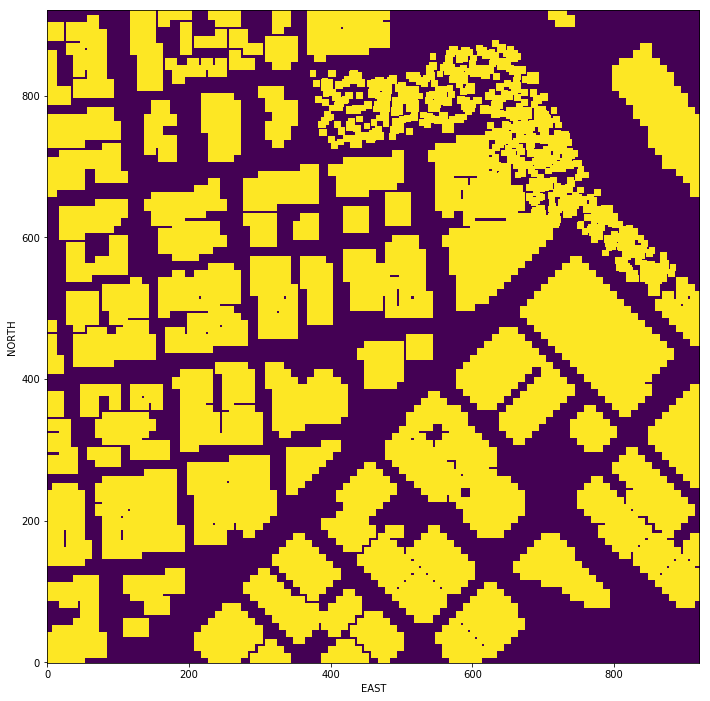

In [9]:
# equivalent to
# plt.imshow(np.flip(grid, 0))
plt.imshow(grid, origin='lower') 

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

Next you'll compute the path from a start location to a goal location using A*.

Start and goal coordinates in *(north, east)*.

In [10]:
start_ne = (25,  100)
goal_ne = (750., 370.)

Write a heuristic function.

In [11]:
def heuristic_func(position, goal_position):
    # Manhattan / Taxi Cab Distance
    return np.abs(position[0] - goal_position[0]) + np.abs(position[1] - goal_position[1])

In [12]:
heuristic_func([0, 0], [1, 1])

2

Compute the lowest cost path with `a_star`. 

In [39]:
%autoreload 2
from planning import a_star

path, cost = a_star(grid, heuristic_func, start_ne, goal_ne, direction_change_cost = None)
print('Length {0}, cost {1}'.format(len(path), cost))

Found a path.
Length 786, cost 8946.0


Let's plot the path!

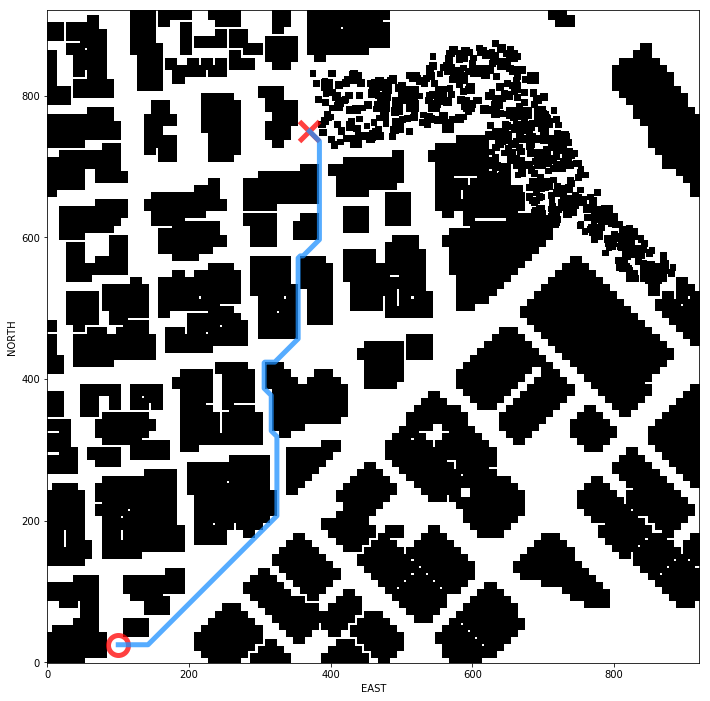

In [40]:
plt.imshow(grid, cmap='Greys', origin='lower')

# For the purposes of the visual the east coordinate lay along
# the x-axis and the north coordinates long the y-axis.
plt.plot(start_ne[1], start_ne[0], 'ro', markersize=20, markeredgewidth=5, fillstyle='none', alpha=0.75)
plt.plot(goal_ne[1], goal_ne[0], 'rx', markersize=20, markeredgewidth=5, alpha=0.75)


if path is not None:
    pp = np.array(path)
    plt.plot(pp[:, 1], pp[:, 0], '-', linewidth=5, color='dodgerblue', alpha=0.75)

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

Let's find another path - this time, we penalize direction changes. In this case, the cost of changing the movement direction is the same as the cost of a regular (i.e. nondiagonal) one.

In [51]:
%autoreload 2
from planning import a_star

path, cost = a_star(grid, heuristic_func, start_ne, goal_ne, direction_change_cost=10)
print('Length {0}, cost {1}'.format(len(path), cost))

Found a path.
Backtracking from ((750, 370), False)
Length 768, cost 9094.0


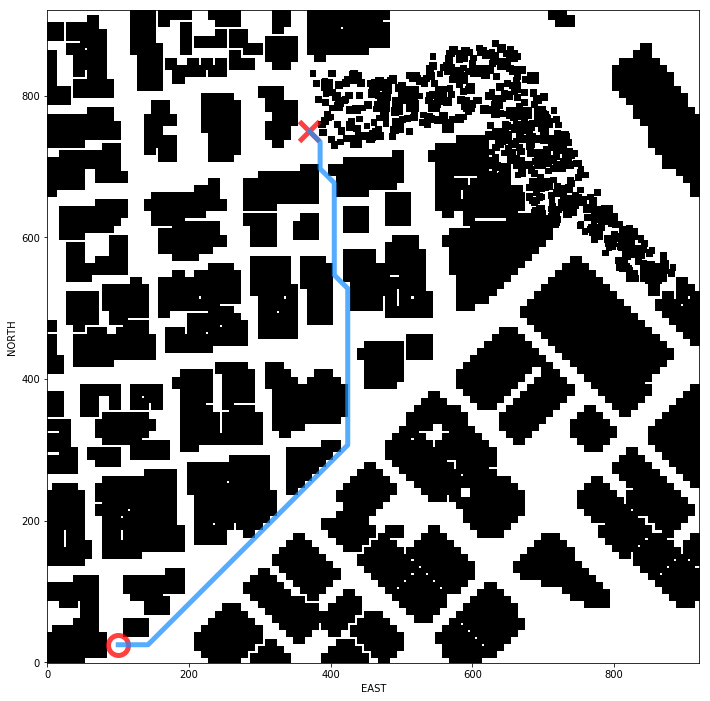

In [52]:
plt.imshow(grid, cmap='Greys', origin='lower')

# For the purposes of the visual the east coordinate lay along
# the x-axis and the north coordinates long the y-axis.
plt.plot(start_ne[1], start_ne[0], 'ro', markersize=20, markeredgewidth=5, fillstyle='none', alpha=0.75)
plt.plot(goal_ne[1], goal_ne[0], 'rx', markersize=20, markeredgewidth=5, alpha=0.75)


if path is not None:
    pp = np.array(path)
    plt.plot(pp[:, 1], pp[:, 0], '-', linewidth=5, color='dodgerblue', alpha=0.75)

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

Pretty neat! Unfortunately this path is impractical, the drone would be constantly stopping and going since each grid cell visited is synonymous with a waypoint. Ideally, we'd like to only consider a new waypoint when the drone's direction changes. Path pruning is one way to achieve this result.

### Path Pruning

In [53]:
def point(p):
    return np.array([p[0], p[1], 1.]).reshape(1, -1)

def collinearity_check(p1, p2, p3, epsilon=1e-6):   
    m = np.concatenate((p1, p2, p3), 0)
    det = np.linalg.det(m)
    return abs(det) < epsilon

Complete the `prune_path` function below. It should return a new path much shorter than the original.

In [54]:
def prune_path(path):
    if path is None:
        return path
    
    # We're gong to mutate the list as we iterate
    # over it. Because of that, we create a copy first.
    pruned_path = [p for p in path]
    
    i = 0
    while i < len(pruned_path) - 2:
        p1 = point(pruned_path[i])
        p2 = point(pruned_path[i+1])
        p3 = point(pruned_path[i+2])
        
        # If the three points are not collinear, check the next
        # thee points by setting the middle point as the new start.
        if not collinearity_check(p1, p2, p3):
            i += 1
            continue

        # The three points are collinear, so remove the middle
        # one; if we do that, the third point becomes the "new" second 
        # one. We continue just like that, collapsing all following 
        # collinear points from here on.
        # That's bad news for the list due to constant copying, 
        # but it gets the job done.
        pruned_path.remove(pruned_path[i+1])

    return pruned_path

Prune the path.

In [58]:
pruned_path = prune_path(path)
print('Length {0}'.format(len(pruned_path)))

Length 9


In [59]:
pruned_path

[(25, 100),
 (25, 142),
 (307, 424),
 (528, 424),
 (547, 405),
 (677, 405),
 (697, 385),
 (735, 385),
 (750.0, 370.0)]

Replot the path, it will be the same as before but the drone flight will be much smoother.

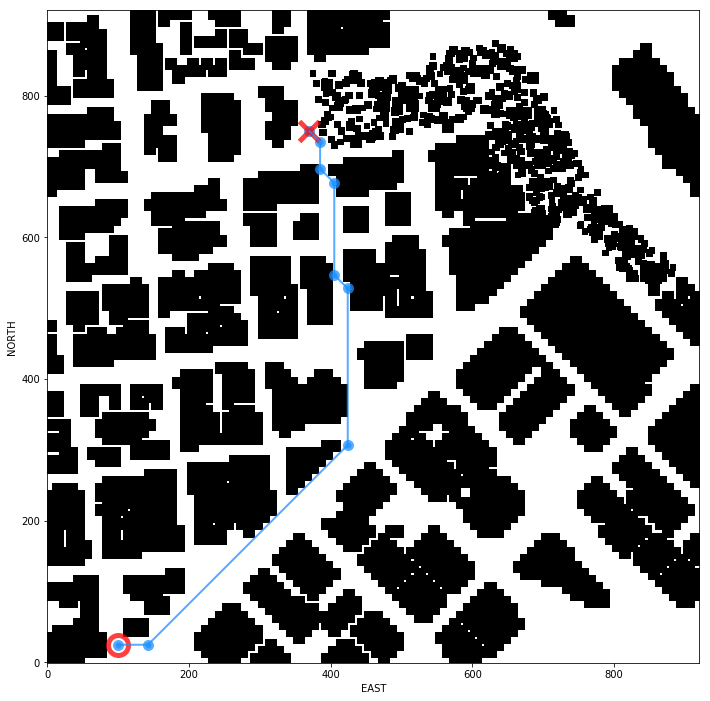

In [60]:
plt.imshow(grid, cmap='Greys', origin='lower')

plt.plot(start_ne[1], start_ne[0], 'ro', markersize=20, markeredgewidth=5, fillstyle='none', alpha=0.75)
plt.plot(goal_ne[1], goal_ne[0], 'rx', markersize=20, markeredgewidth=5, alpha=0.75)

if pruned_path is not None:
    pp = np.array(pruned_path)
    plt.plot(pp[:, 1], pp[:, 0], '-', linewidth=2, color='dodgerblue', alpha=0.75)
    plt.scatter(pp[:, 1], pp[:, 0], linewidth=5, color='dodgerblue', alpha=0.75)

plt.xlabel('EAST')
plt.ylabel('NORTH')

plt.show()

Now the waypoints symbolize a change in direction, much better!

[solution](/notebooks/A-Star-City-Solution.ipynb)